# Notas personales de conceptos de Sistemas de Recomendación:

***

- `Matriz de útilidad`: posee las preferencias de un usuario; pueden tener un origen explícito (dado por el usuario) o implícito ( se deduce a partir del información del usuario). Las columnas no representan variables, simo items. A nivel computacional, no se carga la matriz para no ocupar memoria con los espacios nulos. Es por eso que trabajamos con un data frame en donde solo se cargan los datos con información en forma de filas.

- `Métricas de Distancia`
 - Jaccard: determina la similaridad según la cantidad de elementos en común de los conjuntos. Siempre acúa en parejas. 
 - Coseno: determina similaridad según ángulo del vector. Vectores similaes: ángulo menor a 90 grados (relación directa); Vector Ortogonal: cercano a los 90 grados (no hay correlación; Vectores opuestos. ángulo cercano a 180 grados (relación inversa). 


***


- `Filtro colaborativo`: inferencia en función de la comparación entre las preferencias de un usuario y las preferencias de otro usuario similar. Ventajas: solo necesito la matriz de utilidad, no necesito conocer los items. Desventaja: necesito la matriz de utilidad. 

- `¿Cómo funciona?`
 - Segmenta usuarios en función de variables similares.
 - Utiliza la matriz de utilidad y métricas de distancia Jaccard y Coseno.
 - Recomendamos en función de la distancia.


***


- `Filtro basado en contenidos`: inferencia en función del las variables del producto preferido por el usuario. Se recomiendan elementos con caracterísitcas similares. Resuelve el Cold Start (no tenemos información de consumo del usuario); en principio recomienda elementos parecidos a los gustos señalados por el usuario. Se requiere una bdd bien constituida con buena metadata. Tiende a recomendar más de lo mismo. Basta con tener una sola transacción para buscar qué más se puede recomendar. Desventaja: calcular la similitud entre dos items puede ser una tarea dificil y costosa; suele recomenar items que no son novedosos para el usuario. 

- `¿Cómo funciona?`
 - Para cada item se contruye un perfil (no usa matriz de utilidad, cada columna representa una variable)
 - Usamos una métrica de distancia para encontrar items similares: Jaccard o Coseno.
 - Recomendamos

***

Es posible combinar el filtro colaborativo con basado en contenidos. 
 
***

`Recomendaciones en el marco de grandes dataset`
    - Muestrear, no es necesario usar todo el dataset.
    - Usar partial_fit (de manera de ir ingresando lotes de datos y mejorar el modelo sin colapsar toda la memoria).

***

El objetivo de un sistema de recomendación es poblar los datos faltantes de la matriz de utilidad con los elementos más probables en función de la similitud con los demás usuarios.

***

`Descomposición UV`

- Toda matriz positiva se puede descomponer en tres matrices. 

- Lo que hacemos es una reducción de dimensionalidad, con la que puedo ver la misma información con menos dimensiones sin sacrificar información (varianza). 

- En la medida en que se reduce dimensionalidad, podemos representar la claridad de los datos. Pues nos vamos quedando con los datos con mayor varianza. 

- En el caso del filtro colaborativo descomponemos la matriz original en dos: U (filas * hiperparámetro: factores esperados de los datos (cantidad de agrupaciones -categorías-: viendo qué hiperparámetro devuelve una matriz más parecida a la original) * V(cantidad de columnas por el hiperparámetro). 

- Si aplicamos el dot product de entre filas (usuarios) y columnas (items) corriespondentes entre las dos matrices no originales, y luego los sumamos, obtendremos el valor de la matriz original. Es en base a esta lógica que podemos llenar registros de la matrix original que están en blanco.

***

`¿Cómo encontrar los valores para U y V?`
- definimos una métrica de error (en general RMSE)
- comparamos la matriz observada con la reproducida
- hacemos descenso por gradiente para evaluar el RMSE para distintos hiperparámetros (función de costo).
 - buscamos el valor mínimo del error en función del hiperparámetro.
 - para saber que el error no es local sino global (aplico un randomsearch, comparo y verifico que si es similar voy por buen camino)
 - para ver que el modelo no este overfiteado: 
 - aplico cross validation
 - aplico boosting
 - regularización

***
`Train Test en Sistemas de Recomendación`

- consideraciones: no siempre se puede tratar el train test de la misma forma.
 - para efectos de SR es importante que tengamos alta cantidad de preferencias (no blancos) tanto en train como test. No nos sirve entrenar o evaluar un modelo con muchos espacios en blanco.
 - para efectos de evaluación se le oculta al modelo la fracción de datos correspondiente a las últimas transacciones en train e incorporo en test. 
 - en esta aplicación de SR utilizaremos una función distinta a la usada con sklearn.
       
       
        






# Sistemas de Recomendación - Netflix Prize Challenge

## Filtro Colaborativo a partir de descomposición UV

En este notebook vamos a implementar un sistema de recomendación usando un método tipo descomposición UV.

Vamos a usar la biblioteca Surprise. Te recomendamos tener abierta la [documentación](https://surprise.readthedocs.io/en/stable/getting_started.html) a medida que vas recorriendo esta sección.



### 1. Dataset y Train/test split

Carga de datos

In [2]:
pip install surprise

     |████████████████████████████████| 11.8 MB 950 kB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp38-cp38-macosx_10_9_x86_64.whl size=758111 sha256=da1140a60f006f737333f99f926c0c5fa64c587a8803d7b147f18fe65efe70a6
  Stored in directory: /Users/tomtom/Library/Caches/pip/wheels/20/91/57/2965d4cff1b8ac7ed1b6fa25741882af3974b54a31759e10b6
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

from surprise import accuracy
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [57]:
df1 = pd.read_csv('combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [58]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


Primero, llevamos el dataset al formato que le gusta a la biblioteca. ¿En qué orden tienen que estar los atributos? Investigar qué hace la clase `Reader` y cuáles son sus parámetros.

In [59]:
# surprise no trabaja con datos del dataframe, por lo que debemos pasarlo al formato reader
reader = Reader()

Luego, creamos el `Dataset` de Surprise usando `Dataset.load_from_df`

In [60]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df1[['User', 'Movie_id', 'Rating']][:N_filas], reader)

¿Cómo les parece que es mejor hacer el split?¿Dejando películas en test, usuarios o combinaciones?

In [61]:
# fijarse que en este caso no están separados los targets de los features
trainset, testset = train_test_split(data, test_size=.25)

### 2.2 Entrenamiento

Vamos a entrenar un algoritmo SVD. Explorar sus parámetros y su funcionamiento.

In [62]:
# SVD: singular value decomposition (nos hace la partición de matrices U V)
from surprise import SVD
algo = SVD()

Entrenamos sobre el `trainset`

In [63]:
# descompongo la matriz original en dos: U, V
algo.fit(trainset)

Y predecimos sobre el `testset`. Notar que para predecir sobre un conjunto de test se usa la función `test`.

In [64]:
# en base a las dos matrices creadas, predecimos los los valores aplicandole predicciones al testeset
# U*V 
predictions = algo.test(testset)

Explorar las característica de `predictions` y alguno de sus elementos

In [65]:
# de la librería accuracy traemos rmse para evaluar 
accuracy.rmse(predictions)

RMSE: 1.0524


1.0523661762037293

In [66]:
predictions[1]

# uid= usuario
# iid = película
# r_ui = puntuación real
# est = puntuación estimada

Prediction(uid=1181605, iid=5, r_ui=4.0, est=3.9841759922168727, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y una película en particular, usamos la función `predict`

In [67]:
algo.predict(1328945,28)

Prediction(uid=1328945, iid=28, r_ui=None, est=3.855178127864055, details={'was_impossible': False})

Exploremos un usuario, veamos cuáles películas le gustaron y cuáles les recomienda el sistema.

Películas que le gustaron

In [68]:
usuario = 1539350
rating = 5   # le pedimos peliculas a las que haya puesto 5 estrellas
df_user = df1[(df1['User'] == usuario) & (df1['Rating'] >= rating)]
df_user = df_user.reset_index(drop=True)
df_user['Name'] = df_title['Name'].loc[df_user.Movie_id].values
df_user

,User,Rating,Movie_id,Name
0,1539350,5,269,Parenthood
1,1539350,5,270,Sex and the City: Season 4
2,1539350,5,406,Hostage
3,1539350,5,1202,National Lampoon's Vacation
4,1539350,5,2862,The Silence of the Lambs
5,1539350,5,3151,Napoleon Dynamite
6,1539350,5,3605,The Wizard of Oz: Collector's Edition
7,1539350,5,3928,Nip/Tuck: Season 2
8,1539350,5,4159,Barbershop


Creamos donde vamos a guardar las recomendaciones

In [69]:
# creamos una copia con las recomendaciones de usuario
recomendaciones_usuario = df_title.iloc[:4499].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


# Ya sabemos lo que vio ese usuario en particular; ahora queremos saber qué `no vio`

In [70]:
# removemos del dataframe todas las películas que ya sabemos que vio
usuario_vistas = df1[df1['User'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(97, 3)


,User,Rating,Movie_id
219870,1539350,3,33
409717,1539350,4,111
445206,1539350,3,127
664099,1539350,4,175
894718,1539350,4,197


In [71]:
# eliminamos sobre recomendaciones usuarios (todas las películas), todas las que vió
# nos quedamos todas las películas que no vio
recomendaciones_usuario.drop(usuario_vistas.Movie_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,Movie_Id,Name
0,1,Dinosaur Planet
1,2,Isle of Man TT 2004 Review
2,3,Character
3,4,Paula Abdul's Get Up & Dance
4,5,The Rise and Fall of ECW


Y hacemos las recomendaciones

In [72]:
# sobre las películas (x) que no vio el usuario, predice un estimado del ranking que le daría.
# guardamos en nueva columna: Estimate_Score
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['Movie_Id'].apply(lambda x: algo.predict(usuario, x).est)

In [79]:
# ordenamos las películas sugeridas en función de Estimate_Score
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario= recomendaciones_usuario.reset_index(drop=True)
recomendaciones_usuario.head(10)

,Movie_Id,Name,Estimate_Score
0,13,Lord of the Rings: The Return of the King: Ext...,4.608476
1,25,Inspector Morse 31: Death Is Now My Neighbour,4.003418
2,5,The Rise and Fall of ECW,3.984176
3,28,Lilo and Stitch,3.855178
4,18,Immortal Beloved,3.819124
5,1,Dinosaur Planet,3.780492
6,30,Something's Gotta Give,3.732424
7,2,Isle of Man TT 2004 Review,3.694937
8,3,Character,3.689205
9,29,Boycott,3.653270


### 2. Evaluación

Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a las películas. Para eso, buscar en la documentación cómo se hace.

In [23]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.0528


1.052756403295485

### 3. Optimización de parámetros

**Ejercicio**: hacer un gráfico del desempeño del modelo en función del número de factores del `SVD`

In [24]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0492  1.0397  1.0486  1.0459  0.0044  
Fit time          0.78    0.73    0.71    0.74    0.03    
Test time         0.25    0.19    0.13    0.19    0.05    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0445  1.0459  1.0435  1.0446  0.0010  
Fit time          0.75    0.75    0.78    0.76    0.01    
Test time         0.13    0.15    0.13    0.14    0.01    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0461  1.0464  1.0445  1.0457  0.0009  
Fit time          0.86    0.79    0.82    0.82    0.03    
Test time         0.21    0.13    0.13    0.15    0.04    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

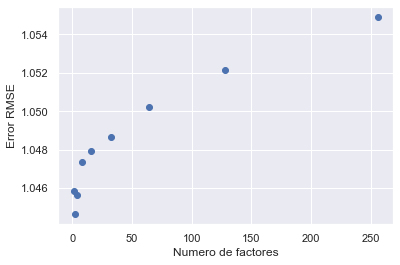

In [25]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

**Ejercicio**: recordar que, cuando entrenamos un `SVD`, estamos usando descenso por gradiente para minimizar una función de costo. Usar `GridSearchCV` para buscar valores óptimos para los siguientes parámetros (tres por parámetros, utilizar los valores default de referencia): `n_factors`, `n_epochs`, `lr_all` y `reg_all`. Estudiar qué representa cada uno de ellos mientras esperan. Tomarse un café.

In [26]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)


In [27]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.045412811279208
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


## Extra: Agrandando el Dataset

Podemos sumar al dataset el resto de las calificaciones que no usamos.

Como corremos el riesgo de que se nos llene la memoria RAM, vamos a hacerlo de a poco y con cuidado. Arrancamos agregando las calificaciones que hay en `combined_data_2.txt`.

0. Reiniciar el Kernel
1. Abrir el archivo `combined_data_2.txt` con la función `load_data`.
2. Agregar una columna con el `Movie_id` al que corresponden las calificaciones. Si te animas, puedes crear una función que realice este paso.
3. Opcional: filtrar películas con pocas calificaciones
4. Abrir el archivo donde ya está procesado `combined_data_1.txt`. 
5. Agregar al final las nuevas calificaciones y guardarlo en un nuevo archivo.


Una vez que estén contentos con el procedimientos, repetir los pasos anteriores para los archivos faltantes.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

In [30]:
### 1

def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    return df


df2 = load_data('combined_data_2.txt')
print(df2.shape)

(26982302, 2)


In [31]:
### 2.
movies_ids_df2 = df2.User[df2.Rating.isna()].values
print(movies_ids_df2)
print(len(movies_ids_df2))

movies_ids_df2 = np.arange(4500,len(movies_ids_df2) + 4500)
print(movies_ids_df2)

['4500:' '4501:' '4502:' ... '9208:' '9209:' '9210:']
4711
[4500 4501 4502 ... 9208 9209 9210]


In [32]:
df2_nan = pd.DataFrame(pd.isnull(df2.Rating))
df2_nan = df2_nan[df2_nan['Rating'] == True]
idx_movies_ids = df2_nan.index.values
print(idx_movies_ids)

[       0      259      855 ... 26961403 26980373 26980497]


In [33]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df2.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

array([  259,   596,   105, ..., 18970,   124,  1805])

In [34]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df2[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

In [35]:
df2['Movie_id'] = columna_movie_id
del columna_movie_id

df2.dropna(inplace = True)
df2['User'] = df2['User'].astype(int)
df2['Movie_id'] = df2['Movie_id'].astype(np.int16)
df2['Rating'] = df2['Rating'].astype(np.int8)

gc.collect()

3472

In [36]:
df2

,User,Rating,Movie_id
1,2532865,4,4500
2,573364,3,4500
3,1696725,3,4500
4,1253431,3,4500
5,1265574,2,4500
...,...,...,...
26982297,2420260,1,9210
26982298,761176,3,9210
26982299,459277,3,9210
26982300,2407365,4,9210


In [ ]:
### 4.

df1 = pd.read_csv('combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'Movie_id': np.int16})
print(df1.shape)
df1.head()

In [13]:
### 5.

df = df1.copy()
del df1
df = df.append(df2)
print(df.shape)

(51031355, 3)


Chequeamos que estén todas las películas:

In [14]:
peliculas_presentes = df.Movie_id.unique()
peliculas_presentes

array([   1,    2,    3, ..., 9208, 9209, 9210], dtype=int16)

In [15]:
print((peliculas_presentes - np.arange(1,9210 + 1)).sum())

0


Y guardamos

In [17]:
if True:
    df.to_csv('combined_data_1y2_with_movie_id.csv', index= False)